In [ ]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show_hist
import json
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import shutil
import geopandas as gpd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tifffile import imread
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_fscore_support, jaccard_score
from sklearn.model_selection import RandomizedSearchCV

In [1]:
# Importing MARIDA dataset from directory 
patches = r'E:\MARIDA\patches'
label_Mapping = r'E:\MARIDA\labels_mapping.txt'
Split = r'E:\MARIDA\splits'

# Checking if directories exist
print("Directory 'patches' exists:", os.path.exists(patches))
print("File 'label_Mapping' exists:", os.path.exists(label_Mapping))
print("File 'Split' exists:", os.path.exists(Split))


Directory 'patches' exists: True
File 'label_Mapping' exists: True
File 'Split' exists: True


Image: E:\MARIDA\splits\train\S2_1-12-19_48MYU_0.tif


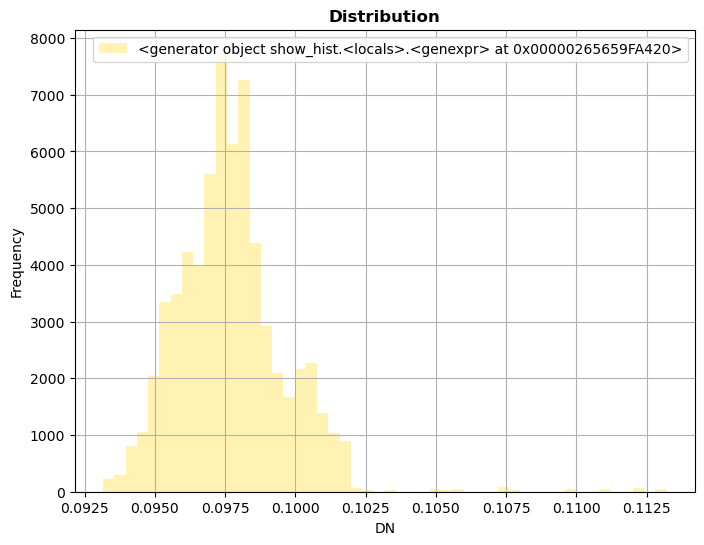

Image: E:\MARIDA\splits\train\S2_1-12-19_48MYU_1.tif


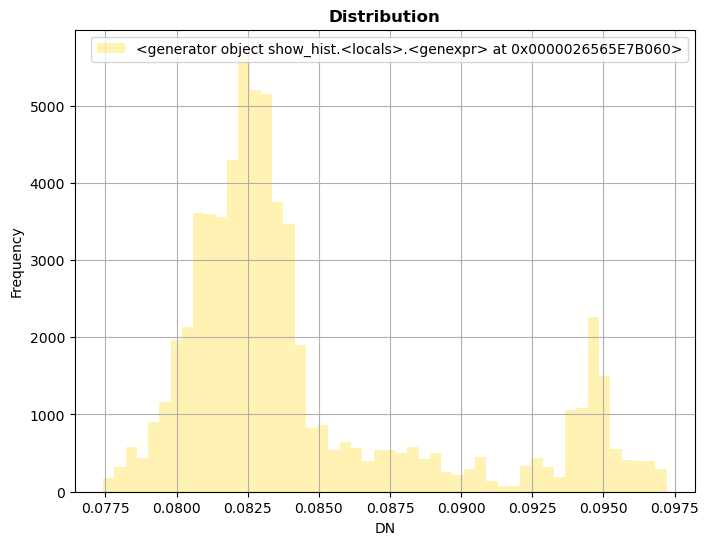

Image: E:\MARIDA\splits\train\S2_1-12-19_48MYU_2.tif


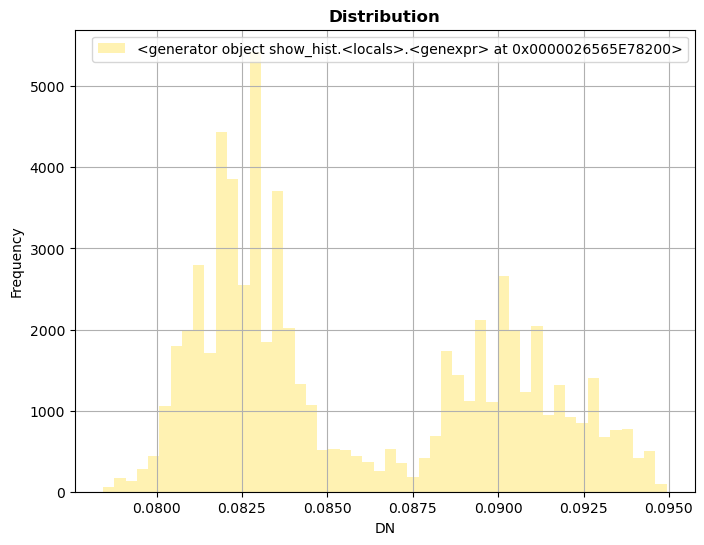

In [2]:
# Plotting examples of pixel distribution
# Defining paths
train_dir = r'E:\MARIDA\splits\train'

# Function to display histogram of pixel distribution
def display_histogram(image_path):
    # Open the image using rasterio
    with rasterio.open(image_path) as src:
        # Read the image as a NumPy array
        image_array = src.read(1)
        
        # Display histogram of pixel distribution
        plt.figure(figsize=(8, 6))
        show_hist(image_array, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Distribution")
        plt.show()

# Get a list of image files in the directory
image_files = [file for file in os.listdir(train_dir) if file.endswith('.tif')]

# Pick some images and display their histograms
for i in range(min(3, len(image_files))):  # Display histograms for 3 images
    image_path = os.path.join(train_dir, image_files[i])
    print("Image:", image_path)
    display_histogram(image_path)


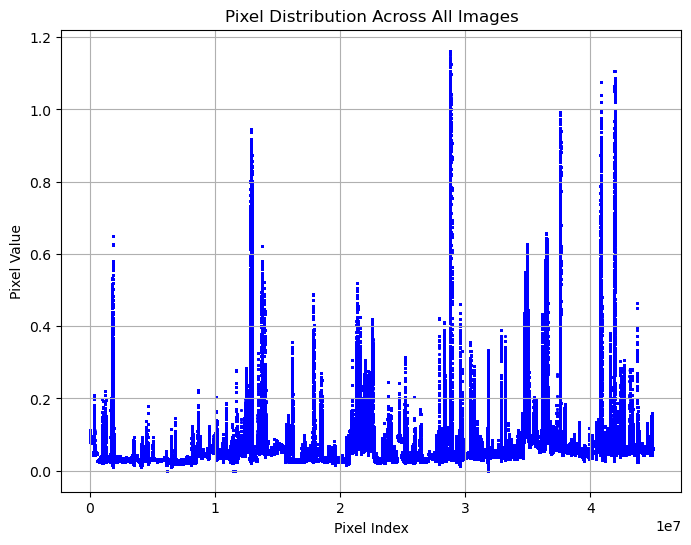

In [3]:
# Plotting all pixel distribution is train set
# Define paths
train_dir = r'E:\MARIDA\splits\train'

# Function to compute pixel values
def compute_pixel_values(image_path):
    # Open the image using rasterio
    with rasterio.open(image_path) as src:
        # Read the image as a NumPy array
        image_array = src.read(1, masked=False) 
        
        # Flatten the image array to 1D
        return image_array.flatten()

# Get a list of image files in the directory
image_files = [file for file in os.listdir(train_dir) if file.endswith('.tif')]

# Compute pixel values for all images
all_pixel_values = []
for image_file in image_files:
    image_path = os.path.join(train_dir, image_file)
    pixel_values = compute_pixel_values(image_path)
    all_pixel_values.extend(pixel_values)

# Plot pixel distribution as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(all_pixel_values)), all_pixel_values, s=1, color='blue', alpha=0.5)
plt.title('Pixel Distribution Across All Images')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Value')
plt.grid(True)
plt.show()


Image: E:\MARIDA\splits\train\S2_1-12-19_48MYU_0.tif
Number of channels: 11


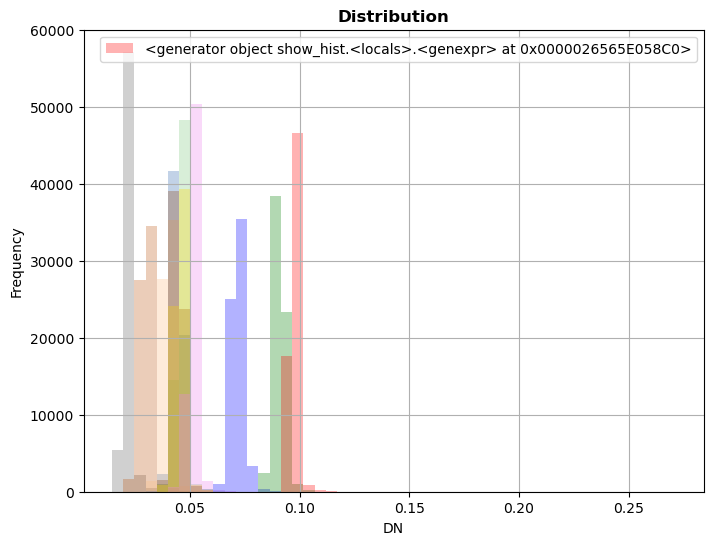

Image: E:\MARIDA\splits\train\S2_1-12-19_48MYU_1.tif
Number of channels: 11


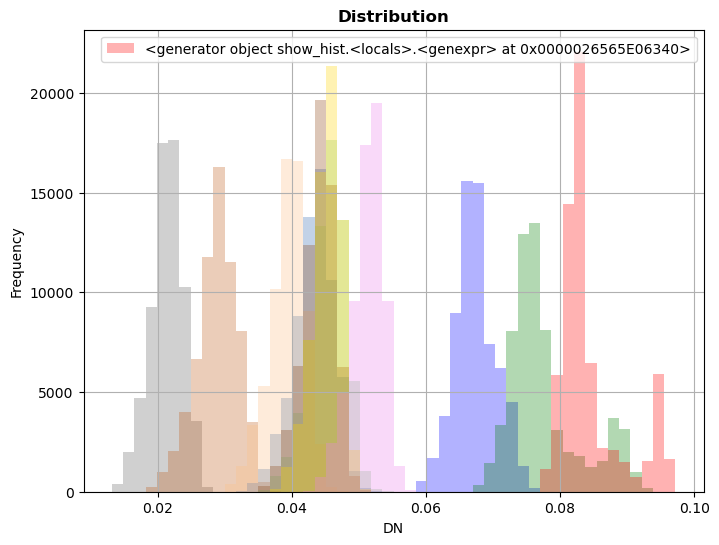

Image: E:\MARIDA\splits\train\S2_1-12-19_48MYU_2.tif
Number of channels: 11


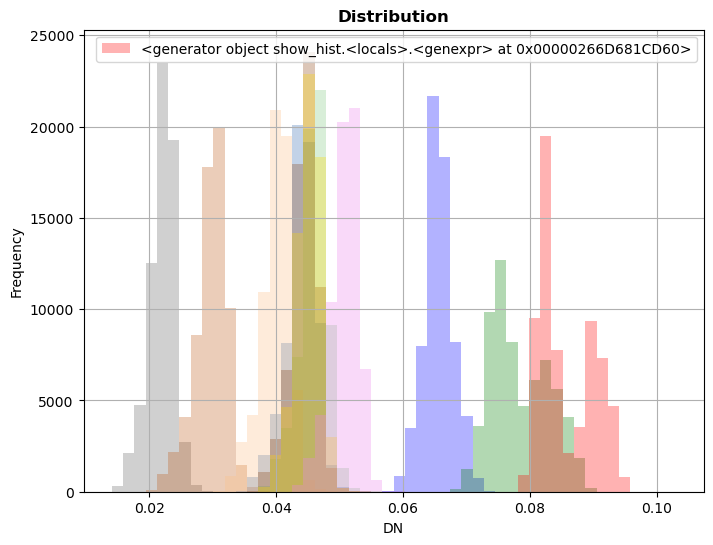

In [4]:
# Plotting channels in 3 examoles of images 

# Define paths
train_dir = r'E:\MARIDA\splits\train'

# Function to display histogram of pixel distribution and print number of channels
def display_histogram(image_path):
    # Open the image using rasterio
    with rasterio.open(image_path) as src:
        # Read the image as a NumPy array
        image_array = src.read()  # Read all bands
        
        # Get shape of the array
        shape = image_array.shape
        
        # Print number of channels
        print("Number of channels:", shape[0])
        
        # Display histogram of pixel distribution
        plt.figure(figsize=(8, 6))
        show_hist(image_array, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Distribution")
        plt.show()

# Get a list of image files in the directory
image_files = [file for file in os.listdir(train_dir) if file.endswith('.tif')]

# Pick some images and display their histograms
for i in range(min(3, len(image_files))):  # Display histograms for at most 3 images
    image_path = os.path.join(train_dir, image_files[i])
    print("Image:", image_path)
    display_histogram(image_path)


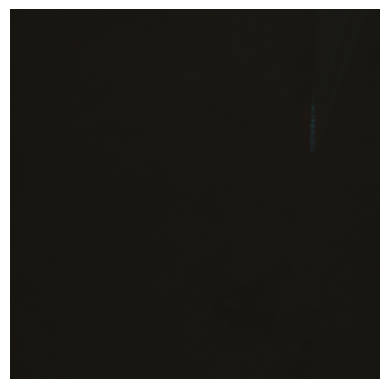

No label file found.


In [5]:
# Plotting an image which has not been mapped yet
# Specify the path to the GeoTIFF image
image_path = r"E:\MARIDA\patches\S2_1-12-19_48MYU\S2_1-12-19_48MYU_0.tif"

# Open the GeoTIFF image
with rasterio.open(image_path) as dataset:
    # Read the image data for the first three bands
    img_data = dataset.read([1, 2, 3])  # Adjust indexes as needed

    # Display the image without color bars
    plt.imshow(img_data.transpose(1, 2, 0))  # Transpose the image data to match Matplotlib's format
    plt.axis('off')  # Turn off axis
    plt.show()

# Check if label file exists
label_file_path = os.path.join(os.path.dirname(image_path), 'label.txt')
if os.path.exists(label_file_path):
    # Read the label from the file
    with open(label_file_path, 'r') as label_file:
        label = label_file.read().strip()
        print("Label:", label)
else:
    print("No label file found.")


In [6]:
# Reading labels-mapping with JSON library 

def parse_labels_mapping(file_path):
    with open(file_path, 'r') as file:
        labels_mapping = json.load(file)
    # Convert string labels into integer lists, if necessary
    for key, value in labels_mapping.items():
        if isinstance(value, str):
            labels_mapping[key] = [int(value)]
        elif isinstance(value, list):
            labels_mapping[key] = [int(label) for label in value]
        else:
            raise ValueError(f"Invalid label format for key '{key}': {value}")
    return labels_mapping

# Adjust the path according to your setup
path_labels_mapping = r'E:\MARIDA\labels_mapping.txt'
labels_mapping = parse_labels_mapping(path_labels_mapping)
#labels_mapping --> If uncommnet this you can see the labels

In [7]:

# Mapping labels_mapping is already populated from the previous code

# Path to the main directory containing subfolders of patches
patches_directory = r'E:\MARIDA\patches'

# Iterate over subdirectories (folders) in the main directory
for root, dirs, files in os.walk(patches_directory):
    for directory in dirs:
        # Get the full path of the current subdirectory
        subdirectory_path = os.path.join(root, directory)
        
        # Iterate over the labels and label the patches based on the filename
        for label, values in labels_mapping.items():
            for value in values:
                # Create a label tag for the patch
                label_tag = f'label_{label}'
                # Form the filename pattern for patches
                patch_filename_pattern = f'patch_{value}.tiff'
                # Iterate over files in the subdirectory
                for filename in os.listdir(subdirectory_path):
                    # Check if the filename matches the pattern
                    if filename == patch_filename_pattern:
                        # Form the new filename with the label tag
                        new_filename = f'{filename[:-5]}_{label_tag}.tiff'
                        # Rename the file with the new filename
                        os.rename(os.path.join(subdirectory_path, filename), os.path.join(subdirectory_path, new_filename))


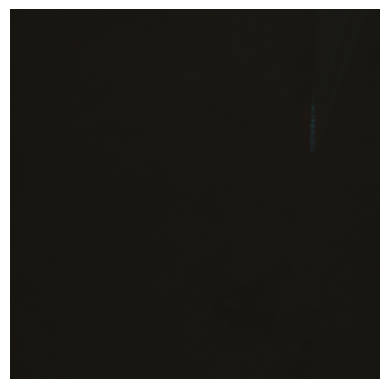

Label: [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]


In [8]:
# Showing binary classes in patches
# Specify the path to the GeoTIFF image
image_path = r"E:\MARIDA\patches\S2_1-12-19_48MYU\S2_1-12-19_48MYU_0.tif"

# Open the GeoTIFF image
with rasterio.open(image_path) as dataset:
    # Read the image data for the first three bands
    img_data = dataset.read([1, 2, 3])  # Adjust indexes as needed

    # Display the image without color bars
    plt.imshow(img_data.transpose(1, 2, 0))  # Transpose the image data to match Matplotlib's format
    plt.axis('off')  # Turn off axis
    plt.show()

# Extract label from the image filename
image_filename = os.path.basename(image_path)
image_label = labels_mapping.get(image_filename, "Label not found")

# Print the label
print("Label:", image_label)


In [9]:
# Converting binary labels to string
def count_images_per_class(data_folder, labels_mapping, class_names):
    class_counts = {class_name: 0 for class_name in class_names.values()}
    
    # Iterate over each subfolder in the data folder
    for folder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder)
        if os.path.isdir(folder_path):
            # Get a list of all image files in the subfolder
            image_files = [file for file in os.listdir(folder_path) if file.endswith('.tif')]
            # Iterate over each image file in the subfolder
            for image_file in image_files:
                label = labels_mapping.get(image_file)
                if label is not None:
                    # Convert the binary labels to a more interpretable format
                    label_classes = [class_names[i] for i in range(len(label)) if i in class_names and label[i] == 1]
                    # Count the images for each class
                    for label_class in label_classes:
                        class_counts[label_class] += 1
                # Remove the print statement here
    return class_counts

# Define the class names and their corresponding binary labels
class_names = {
    0: 'MD',
    1: 'DenS',
    2: 'SPS',
    3: 'NatM',
    4: 'Ship',
    5: 'Cloud',
    6: 'MWater',
    7: 'SLWater',
    8: 'Foam',
    9: 'TWater',
    10: 'SWater',
    11: 'Waves',
    12: 'CloudS',
    13: 'Wakes',
    14: 'MixWater'
}

# Example usage:
data_folder = r'E:\MARIDA\patches'  # Update this to your data folder containing images
class_counts = count_images_per_class(data_folder, labels_mapping, class_names)
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of Patches: {count}")


Class: MD, Number of Patches: 373
Class: DenS, Number of Patches: 49
Class: SPS, Number of Patches: 106
Class: NatM, Number of Patches: 71
Class: Ship, Number of Patches: 182
Class: Cloud, Number of Patches: 181
Class: MWater, Number of Patches: 870
Class: SLWater, Number of Patches: 51
Class: Foam, Number of Patches: 59
Class: TWater, Number of Patches: 220
Class: SWater, Number of Patches: 64
Class: Waves, Number of Patches: 54
Class: CloudS, Number of Patches: 71
Class: Wakes, Number of Patches: 106
Class: MixWater, Number of Patches: 140


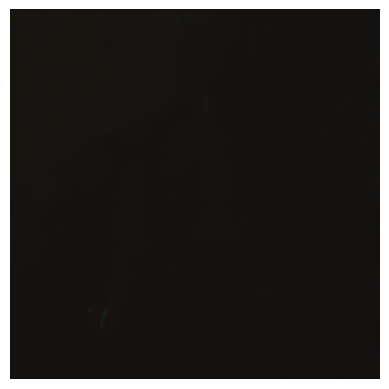

Image: S2_1-12-19_48MYU_3.tif, Classes: ['MD', 'Ship', 'MWater', 'Wakes']


In [10]:
# An example to see the labels are mapped
def print_image_with_classes(image_path, labels_mapping, class_names):
    # Open the GeoTIFF image
    with rasterio.open(image_path) as dataset:
        # Read the image data for the first three bands
        img_data = dataset.read([1, 2, 3])  # Adjust indexes as needed

        # Display the image without color bars
        plt.imshow(img_data.transpose(1, 2, 0))  # Transpose the image data to match Matplotlib's format
        plt.axis('off')  # Turn off axis
        plt.show()

    # Get the filename of the image
    image_filename = os.path.basename(image_path)
    
    # Check if label exists for the image
    if image_filename in labels_mapping:
        # Get the binary label for the image
        binary_label = labels_mapping[image_filename]

        # Get the class names for each class where binary label is 1
        image_class_names = [class_names[i] for i, val in enumerate(binary_label) if val == 1]

        # Print the class names for the image
        print(f"Image: {image_filename}, Classes: {image_class_names}")
    else:
        print(f"Label not found for image: {image_filename}")

# Example usage:
image_path = r"E:\MARIDA\patches\S2_1-12-19_48MYU\S2_1-12-19_48MYU_3.tif"
print_image_with_classes(image_path, labels_mapping, class_names)


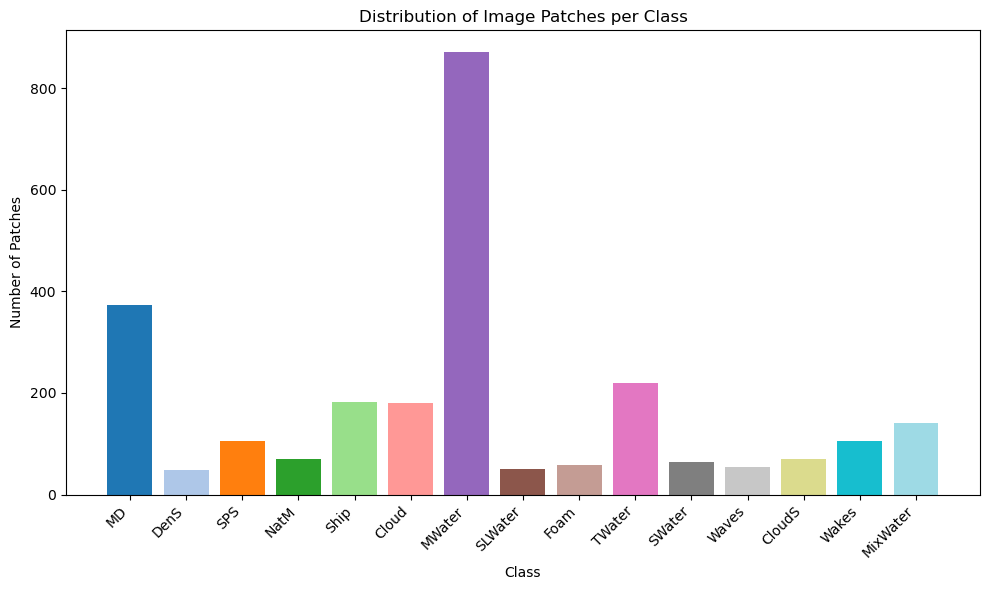

In [11]:
# Plotting ny histogram to see the classes in patches ( THERE ARE 15 CLASSES )
def count_images_per_class(data_folder, labels_mapping, class_names):
    class_counts = {class_name: 0 for class_name in class_names.values()}
    
    # Iterate over each subfolder in the data folder
    for folder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder)
        if os.path.isdir(folder_path):
            # Get a list of all image files in the subfolder
            image_files = [file for file in os.listdir(folder_path) if file.endswith('.tif')]
            # Iterate over each image file in the subfolder
            for image_file in image_files:
                label = labels_mapping.get(image_file)
                if label is not None:
                    # Convert the binary labels to a more interpretable format
                    label_classes = [class_names[i] for i in range(len(label)) if i in class_names and label[i] == 1]
                    # Count the images for each class
                    for label_class in label_classes:
                        class_counts[label_class] += 1
    return class_counts

# Define the class names and their corresponding binary labels
class_names = {
    0: 'MD',
    1: 'DenS',
    2: 'SPS',
    3: 'NatM',
    4: 'Ship',
    5: 'Cloud',
    6: 'MWater',
    7: 'SLWater',
    8: 'Foam',
    9: 'TWater',
    10: 'SWater',
    11: 'Waves',
    12: 'CloudS',
    13: 'Wakes',
    14: 'MixWater'
}

# Example usage:
data_folder = r'E:\MARIDA\patches'  # Update this to your data folder containing images
class_counts = count_images_per_class(data_folder, labels_mapping, class_names)

# Extract class names and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Define colors for each class
colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Patches')
plt.title('Distribution of Image Patches per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


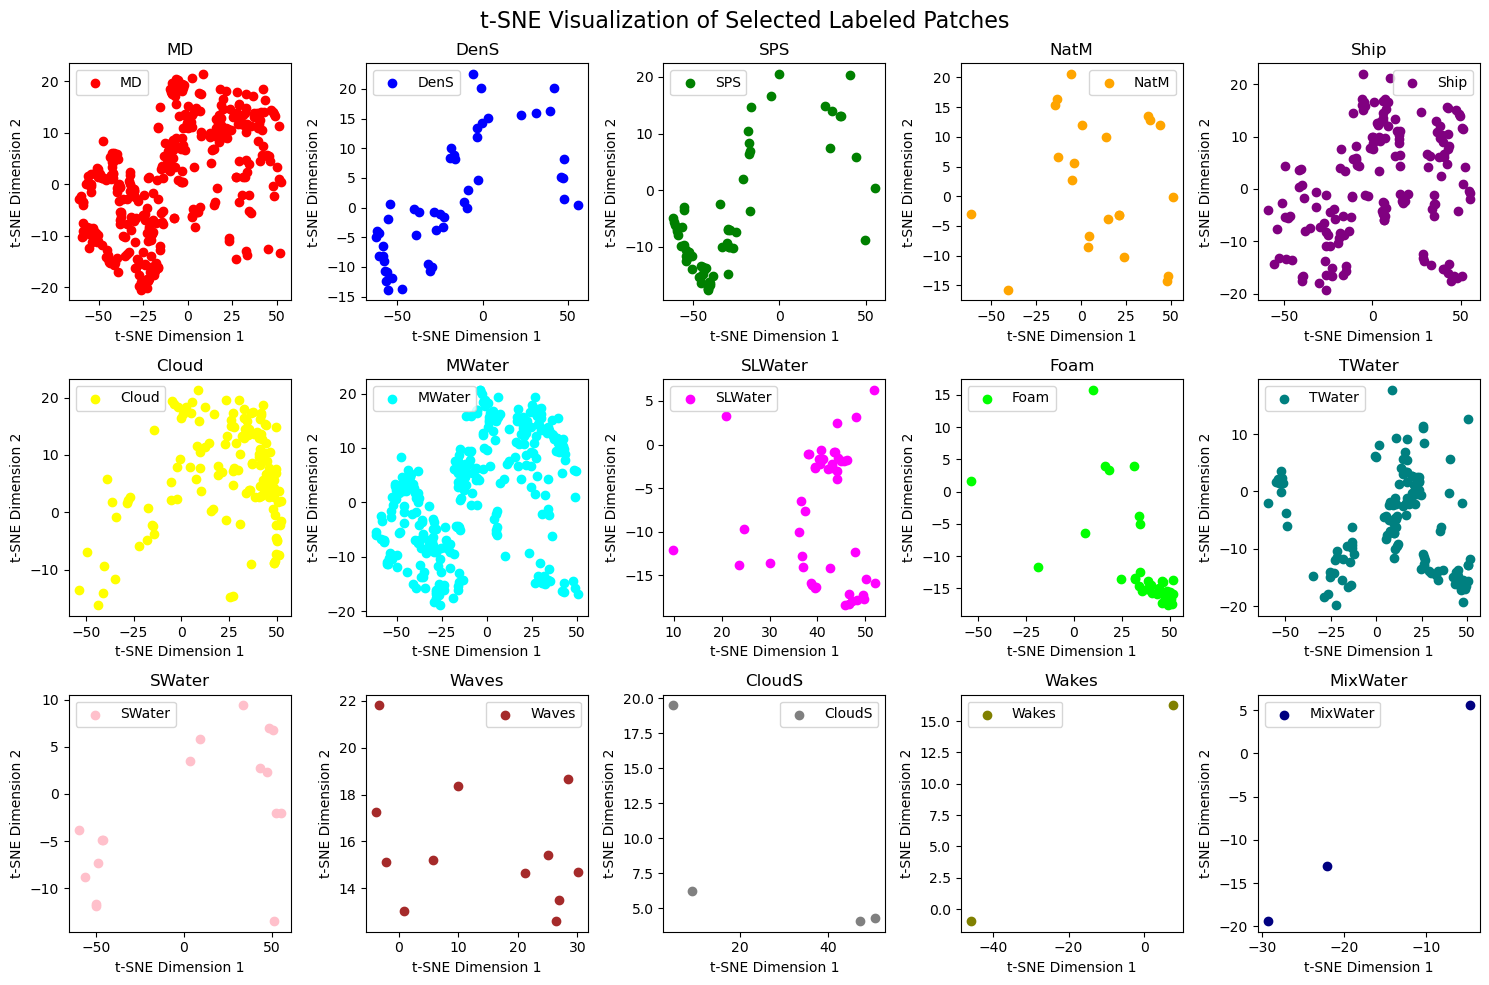

In [16]:
# Visualization with T-SNE 

# Define the class names and their corresponding binary labels
class_names = {
    0: 'MD',
    1: 'DenS',
    2: 'SPS',
    3: 'NatM',
    4: 'Ship',
    5: 'Cloud',
    6: 'MWater',
    7: 'SLWater',
    8: 'Foam',
    9: 'TWater',
    10: 'SWater',
    11: 'Waves',
    12: 'CloudS',
    13: 'Wakes',
    14: 'MixWater'
}

# Define colors for each class
class_colors = {
    'MD': 'red',
    'DenS': 'blue',
    'SPS': 'green',
    'NatM': 'orange',
    'Ship': 'purple',
    'Cloud': 'yellow',
    'MWater': 'cyan',
    'SLWater': 'magenta',
    'Foam': 'lime',
    'TWater': 'teal',
    'SWater': 'pink',
    'Waves': 'brown',
    'CloudS': 'gray',
    'Wakes': 'olive',
    'MixWater': 'navy'
}

# Collect image data and labels for visualization
visualize_data = []
visualize_labels = []

# Load labeled images
for root, dirs, files in os.walk(patches_directory):
    for file in files:
        if file.endswith('.tif'):
            # Check if the image file has a label
            label = labels_mapping.get(file)
            if label is not None:
                # Load the image and convert it to numpy array
                image_path = os.path.join(root, file)
                with rasterio.open(image_path) as src:
                    img = src.read()  # Read the image
                img = np.moveaxis(img, 0, -1)  # Adjust image dimensions
                # Flatten the image data and add it to the visualization data
                visualize_data.append(img.flatten())
                # Add the label to the visualization labels
                visualize_labels.append(class_names[label.index(1)])

# Convert lists to numpy arrays for further processing
visualize_data = np.array(visualize_data)
visualize_labels = np.array(visualize_labels)

# Replace NaN values with the mean of each feature
imputer = SimpleImputer(strategy='mean')
visualize_data_imputed = imputer.fit_transform(visualize_data)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
visualize_tsne = tsne.fit_transform(visualize_data_imputed)

# Plot the t-SNE visualization for each class separately
plt.figure(figsize=(15, 10))
for cls in ['MD', 'NatM', 'SPS', 'Ship', 'Waves']:
    indices = np.where(visualize_labels == cls)
    plt.scatter(visualize_tsne[indices, 0], visualize_tsne[indices, 1], label=cls, color=class_colors[cls])
plt.title('t-SNE Visualization of Selected Labeled Patches')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


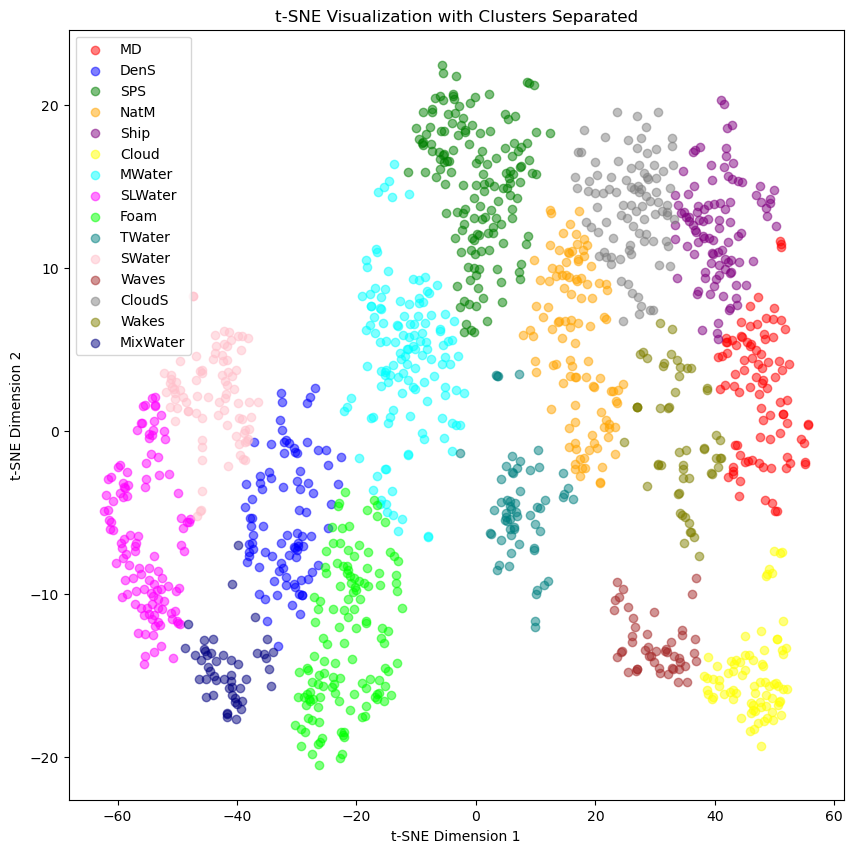

In [31]:
# Visualization with K-mean clustering and T-SNE 
# Define the number of clusters (one for each class)
num_clusters = len(class_names)

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(visualize_tsne)

# Map cluster labels to class colors
cluster_colors = {class_names[i]: class_colors[class_names[i]] for i in range(num_clusters)}

# Plot each cluster separately with assigned class colors
plt.figure(figsize=(10, 10))

for cluster in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster)
    cls = class_names[cluster]
    plt.scatter(visualize_tsne[cluster_indices, 0], visualize_tsne[cluster_indices, 1], label=cls, color=cluster_colors[cls], alpha=0.5)

plt.title('t-SNE Visualization with Clusters Separated')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [9]:
# Chaking the directories in text files
# Paths to directories
split_directory = r'E:\MARIDA\splits'  # Directory containing split text files

# Function to count the number of lines in a file
def count_lines(file_path):
    with open(file_path, 'r') as file:
        return sum(1 for line in file)

# Read file names for train, test, and validation sets
train_file_path = os.path.join(split_directory, 'train_X.txt')
test_file_path = os.path.join(split_directory, 'test_X.txt')
val_file_path = os.path.join(split_directory, 'val_X.txt')

# Count the number of lines in each file
num_train_lines = count_lines(train_file_path)
num_test_lines = count_lines(test_file_path)
num_val_lines = count_lines(val_file_path)

# Print the number of lines in each file
print("Number of lines in train_X.txt:", num_train_lines)
print("Number of lines in test_X.txt:", num_test_lines)
print("Number of lines in val_X.txt:", num_val_lines)


Number of lines in train_X.txt: 694
Number of lines in test_X.txt: 359
Number of lines in val_X.txt: 328


In [10]:
# Splitting MARIDA dataset after mapping --> Copy the desired patches into new files
# Function to load split IDs from a file
def load_split(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file.readlines()]

# Function to recursively collect image files from subdirectories
def collect_image_files(root_dir):
    image_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.tif'):
                image_files.append(os.path.join(root, file))
    return image_files

# Function to copy images based on split IDs
def copy_images(split_ids, source_files, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for id in split_ids:
        source_path = None
        for file in source_files:
            if id in file:
                source_path = file
                break
        if source_path:
            target_path = os.path.join(target_dir, os.path.basename(source_path))
            shutil.copyfile(source_path, target_path)
        else:
            print(f"Image file for ID '{id}' not found.")

# Paths to patches and splits directories
path_patches = r'E:\MARIDA\patches'
path_splits = r'E:\MARIDA\splits'

# Load split IDs
path_train_split = os.path.join(path_splits, 'train_X.txt')
path_val_split = os.path.join(path_splits, 'val_X.txt')
path_test_split = os.path.join(path_splits, 'test_X.txt')

train_ids = load_split(path_train_split)
val_ids = load_split(path_val_split)
test_ids = load_split(path_test_split)

# Collect image files recursively
image_files = collect_image_files(path_patches)

# Split the data
train_dir = os.path.join(path_splits, 'train')
val_dir = os.path.join(path_splits, 'val')
test_dir = os.path.join(path_splits, 'test')

# Copy images based on split IDs
copy_images(train_ids, image_files, train_dir)
copy_images(val_ids, image_files, val_dir)
copy_images(test_ids, image_files, test_dir)

print("Data split completed.")


Data split completed.


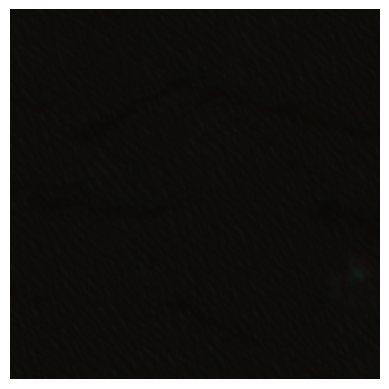

Image: S2_11-6-18_16PCC_46.tif, Classes: ['MWater', 'Waves']


In [32]:
# Plotting to see if split is correct or not

def print_image_with_classes(image_path, labels_mapping, class_names):
    # Open the GeoTIFF image
    with rasterio.open(image_path) as dataset:
        # Read the image data for the first three bands
        img_data = dataset.read([1, 2, 3])  # Adjust indexes as needed

        # Display the image without color bars
        plt.imshow(img_data.transpose(1, 2, 0))  # Transpose the image data to match Matplotlib's format
        plt.axis('off')  # Turn off axis
        plt.show()

    # Get the filename of the image
    image_filename = os.path.basename(image_path)
    
    # Check if label exists for the image
    if image_filename in labels_mapping:
        # Get the binary label for the image
        binary_label = labels_mapping[image_filename]

        # Get the class names for each class where binary label is 1
        image_class_names = [class_names[i] for i, val in enumerate(binary_label) if val == 1]

        # Print the class names for the image
        print(f"Image: {image_filename}, Classes: {image_class_names}")
    else:
        print(f"Label not found for image: {image_filename}")

# Example usage:
image_path = r"E:\MARIDA\splits\val\S2_11-6-18_16PCC_46.tif"
print_image_with_classes(image_path, labels_mapping, class_names)


In [12]:
# Printing split MARIDA dataset from new files directory
# Define the paths to the train, test, and validation directories
train_dir = r'E:\MARIDA\splits\train'
test_dir = r'E:\MARIDA\splits\test'
val_dir = r'E:\MARIDA\splits\val'

# Function to count the number of files in a directory
def count_files(directory):
    return len([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])

# Count the number of files in each directory
train_files_count = count_files(train_dir)
test_files_count = count_files(test_dir)
val_files_count = count_files(val_dir)

# Print the results
print("Number of files in train directory:", train_files_count)
print("Number of files in test directory:", test_files_count)
print("Number of files in validation directory:", val_files_count)


Number of files in train directory: 687
Number of files in test directory: 359
Number of files in validation directory: 328


In [30]:
# Printing number of classes and patches
def print_classes_with_image_counts(images_dir, labels_mapping, class_names):
    # Initialize a dictionary to store the count of images for each class
    class_counts = {class_name: 0 for class_name in class_names}

    # Iterate over each image in the directory
    for filename in os.listdir(images_dir):
        if filename.endswith('.tif'):
            # Get the binary label for the image
            binary_label = labels_mapping.get(filename)
            if binary_label:
                # Get the class names for each class where binary label is 1
                image_class_names = [class_name for i, class_name in enumerate(class_names) if binary_label[i] == 1]
                # Increment the count for each class
                for class_name in image_class_names:
                    class_counts[class_name] += 1

    # Print the count of images for each class
    for class_name, count in class_counts.items():
        print(f"Class: {class_name}, Number of Images: {count}")

# Example usage:
images_dir = r"E:\MARIDA\splits\train"  # Path to the directory containing the images
print_classes_with_image_counts(images_dir, labels_mapping, class_names)


Class: 0, Number of Images: 186
Class: 1, Number of Images: 24
Class: 2, Number of Images: 56
Class: 3, Number of Images: 34
Class: 4, Number of Images: 88
Class: 5, Number of Images: 92
Class: 6, Number of Images: 425
Class: 7, Number of Images: 24
Class: 8, Number of Images: 30
Class: 9, Number of Images: 115
Class: 10, Number of Images: 37
Class: 11, Number of Images: 23
Class: 12, Number of Images: 39
Class: 13, Number of Images: 49
Class: 14, Number of Images: 66


Shapefile information:
   id  conf  report                                           geometry
0   1     3       3  POLYGON ((710392.326 9335187.253, 710397.150 9...
1   1     3       3  POLYGON ((710421.993 9335247.552, 710427.380 9...
2   1     3       3  POLYGON ((710773.412 9336185.152, 710776.467 9...
3   1     3       3  POLYGON ((710792.225 9336213.934, 710797.853 9...
4   1     3       3  POLYGON ((710811.682 9336246.093, 710816.666 9...


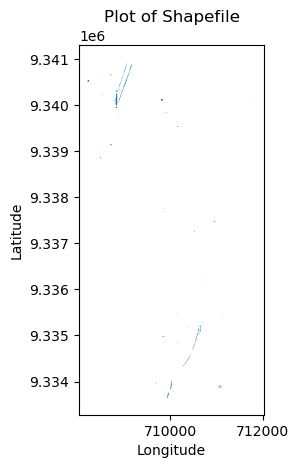

In [14]:
# Visualizaing shapefiles

# Define the directory containing shapefiles
shapefiles_dir = r'E:\MARIDA\shapefiles'

# List all shapefiles in the directory
shapefile_paths = [os.path.join(shapefiles_dir, filename) for filename in os.listdir(shapefiles_dir) if filename.endswith('.shp')]

# Read the first shapefile
if shapefile_paths:
    first_shapefile_path = shapefile_paths[0]
    gdf = gpd.read_file(first_shapefile_path)
    print("Shapefile information:")
    print(gdf.head())  # Display the first few rows of the shapefile data
    
    # Plot the shapefile
    gdf.plot()
    plt.title("Plot of Shapefile")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("No shapefiles found in the directory:", shapefiles_dir)


In [53]:
# Creating Decision Trees Model --> First Model

# Define paths
train_dir = r'E:\MARIDA\splits\train'
val_dir = r'E:\MARIDA\splits\val'
test_dir = r'E:\MARIDA\splits\test'
label_mapping_file = r'E:\MARIDA\labels_mapping.txt'

# Parse labels mapping
with open(label_mapping_file, 'r') as file:
    labels_mapping = json.load(file)

# Function to load TIFF images and labels
def load_tiff_images_and_labels(directory, labels_mapping):
    images = []
    labels = []
    for filename, class_labels in labels_mapping.items():
        image_path = os.path.join(directory, filename)
        if os.path.exists(image_path):
            image = imread(image_path)
            images.append(image)
            labels.append(class_labels)
    return np.array(images), np.array(labels)

# Load training data
train_images, train_labels = load_tiff_images_and_labels(train_dir, labels_mapping)
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

# Load validation data
val_images, val_labels = load_tiff_images_and_labels(val_dir, labels_mapping)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

# Load test data
test_images, test_labels = load_tiff_images_and_labels(test_dir, labels_mapping)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Flatten images
train_images = train_images.reshape(train_images.shape[0], -1)
val_images = val_images.reshape(val_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Define the decision tree classifier
model = DecisionTreeClassifier()

# Train the model
model.fit(train_images, train_labels)

# Evaluate the model on validation data
val_predictions = model.predict(val_images)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on test data
test_predictions = model.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)


Train images shape: (687, 256, 256, 11)
Train labels shape: (687, 15)
Validation images shape: (328, 256, 256, 11)
Validation labels shape: (328, 15)
Test images shape: (359, 256, 256, 11)
Test labels shape: (359, 15)
Validation Accuracy: 0.11585365853658537
Test Accuracy: 0.14206128133704735


In [54]:
# Fine Tuning the model --> Regularizing Hyperparameters with GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the grid search object
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)

# Perform grid search cross-validation
grid_search.fit(train_images, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model for prediction
best_model = grid_search.best_estimator_

# Evaluate the best model on validation data
val_predictions = best_model.predict(val_images)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Evaluate the best model on test data
test_predictions = best_model.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)


C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Nima\anaconda3\Lib\site-packages\sk

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Validation Accuracy: 0.18597560975609756
Test Accuracy: 0.1977715877437326


In [55]:
# Printing F1 Score

# Calculate F1 score on validation data
val_f1_score = f1_score(val_labels, val_predictions, average='weighted')
print("Validation F1 Score:", val_f1_score)

# Calculate F1 score on test data
test_f1_score = f1_score(test_labels, test_predictions, average='weighted')
print("Test F1 Score:", test_f1_score)


Validation F1 Score: 0.3528455834214161
Test F1 Score: 0.3830118751680151


In [56]:
#  calculating Precision Accuracy (PA)
def precision_accuracy(y_true, y_pred):
    return np.sum(np.logical_and(y_true, y_pred)) / np.sum(np.logical_or(y_true, y_pred))

# Calculate PA on validation data
val_pa = precision_accuracy(val_labels, val_predictions)
print("Validation PA:", val_pa)

# Calculate PA on test data
test_pa = precision_accuracy(test_labels, test_predictions)
print("Test PA:", test_pa)


Validation PA: 0.2848101265822785
Test PA: 0.30257009345794394


In [57]:
#  calculating Intersection over Union (IoU)
def intersection_over_union(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    return intersection / union

# Calculate IoU on validation data
val_iou = intersection_over_union(val_labels, val_predictions)
print("Validation IoU:", val_iou)

# Calculate IoU on test data
test_iou = intersection_over_union(test_labels, test_predictions)
print("Test IoU:", test_iou)


Validation IoU: 0.2848101265822785
Test IoU: 0.30257009345794394


In [61]:
# Printing scores over classes
# Find unique classes in the labels
unique_classes = np.unique(train_labels)
class_names = [str(label) for label in unique_classes]

print("Unique classes:", class_names)

# Compute classification report for validation data
val_classification_report = classification_report(val_labels, val_predictions, labels=unique_classes, target_names=class_names)
print("Validation Classification Report:")
print(val_classification_report)

# Compute classification report for test data
test_classification_report = classification_report(test_labels, test_predictions, labels=unique_classes, target_names=class_names)
print("Test Classification Report:")
print(test_classification_report)


Unique classes: ['0', '1']
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.16      0.21        82
           1       0.00      0.00      0.00        12

   micro avg       0.30      0.14      0.19        94
   macro avg       0.15      0.08      0.10        94
weighted avg       0.26      0.14      0.18        94
 samples avg       0.04      0.04      0.04        94

Test Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.12      0.15       101
           1       0.00      0.00      0.00        13

   micro avg       0.18      0.11      0.13       114
   macro avg       0.10      0.06      0.07       114
weighted avg       0.17      0.11      0.13       114
 samples avg       0.03      0.03      0.03       114



C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classif

In [4]:
# Crearing Second Model --> Random Forest

# Define paths
train_dir = r'E:\MARIDA\splits\train'
val_dir = r'E:\MARIDA\splits\val'
test_dir = r'E:\MARIDA\splits\test'
label_mapping_file = r'E:\MARIDA\labels_mapping.txt'

# Parse labels mapping
with open(label_mapping_file, 'r') as file:
    labels_mapping = json.load(file)

# Function to load TIFF images and labels
def load_tiff_images_and_labels(directory, labels_mapping):
    images = []
    labels = []
    for filename, class_labels in labels_mapping.items():
        image_path = os.path.join(directory, filename)
        if os.path.exists(image_path):
            image = imread(image_path)
            images.append(image)
            labels.append(class_labels)
    return np.array(images), np.array(labels)

# Load training data
train_images, train_labels = load_tiff_images_and_labels(train_dir, labels_mapping)
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

# Load validation data
val_images, val_labels = load_tiff_images_and_labels(val_dir, labels_mapping)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

# Load test data
test_images, test_labels = load_tiff_images_and_labels(test_dir, labels_mapping)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Flatten images
train_images = train_images.reshape(train_images.shape[0], -1)
val_images = val_images.reshape(val_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
train_images_imputed = imputer.fit_transform(train_images)
val_images_imputed = imputer.transform(val_images)
test_images_imputed = imputer.transform(test_images)

# Define the random forest classifier
model = RandomForestClassifier()

# Train the model
model.fit(train_images_imputed, train_labels)

# Evaluate the model on validation data
val_predictions = model.predict(val_images_imputed)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on test data
test_predictions = model.predict(test_images_imputed)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)


Train images shape: (687, 256, 256, 11)
Train labels shape: (687, 15)
Validation images shape: (328, 256, 256, 11)
Validation labels shape: (328, 15)
Test images shape: (359, 256, 256, 11)
Test labels shape: (359, 15)
Validation Accuracy: 0.2225609756097561
Test Accuracy: 0.233983286908078


In [5]:
# Printing Scores for the Second Model

# Calculate F1 score
f1 = f1_score(test_labels, test_predictions, average='weighted')
print("F1 Score:", f1)

# Calculate IOU (Intersection over Union)
iou = jaccard_score(test_labels, test_predictions, average='weighted')
print("IOU:", iou)

# Calculate Precision, Recall, and F1 Score
precision, recall, fscore, _ = precision_recall_fscore_support(test_labels, test_predictions, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score (PR):", fscore)


F1 Score: 0.3719531212688263
IOU: 0.30259832986649593
Precision: 0.47471347115142926
Recall: 0.3804511278195489
F1 Score (PR): 0.3719531212688263


C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Printing over classes

# Find unique classes in the labels
unique_classes = np.unique(train_labels)
class_names = [str(label) for label in unique_classes]

print("Unique classes:", class_names)

# Compute classification report for validation data
val_classification_report = classification_report(val_labels, val_predictions, labels=unique_classes, target_names=class_names)
print("Validation Classification Report:")
print(val_classification_report)

# Compute classification report for test data
test_classification_report = classification_report(test_labels, test_predictions, labels=unique_classes, target_names=class_names)
print("Test Classification Report:")
print(test_classification_report)


Unique classes: ['0', '1']
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.02      0.04        82
           1       0.00      0.00      0.00        12

   micro avg       0.14      0.02      0.04        94
   macro avg       0.07      0.01      0.02        94
weighted avg       0.12      0.02      0.04        94
 samples avg       0.01      0.01      0.01        94

Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.10      0.17       101
           1       0.00      0.00      0.00        13

   micro avg       0.62      0.09      0.15       114
   macro avg       0.31      0.05      0.09       114
weighted avg       0.55      0.09      0.15       114
 samples avg       0.03      0.03      0.03       114



C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nima\anaconda3\Lib\site-packages\sklearn\metrics\_classif

In [ ]:
#Fine tuning with Randomized GridSearchCV

# Define paths
train_dir = r'E:\MARIDA\splits\train'
val_dir = r'E:\MARIDA\splits\val'
test_dir = r'E:\MARIDA\splits\test'
label_mapping_file = r'E:\MARIDA\labels_mapping.txt'

# Parse labels mapping
with open(label_mapping_file, 'r') as file:
    labels_mapping = json.load(file)

# Function to load TIFF images and labels
def load_tiff_images_and_labels(directory, labels_mapping):
    images = []
    labels = []
    for filename, class_labels in labels_mapping.items():
        image_path = os.path.join(directory, filename)
        if os.path.exists(image_path):
            image = imread(image_path)
            images.append(image)
            labels.append(class_labels)
    return np.array(images), np.array(labels)

# Load training data
train_images, train_labels = load_tiff_images_and_labels(train_dir, labels_mapping)
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

# Load validation data
val_images, val_labels = load_tiff_images_and_labels(val_dir, labels_mapping)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

# Load test data
test_images, test_labels = load_tiff_images_and_labels(test_dir, labels_mapping)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Flatten images
train_images = train_images.reshape(train_images.shape[0], -1)
val_images = val_images.reshape(val_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
train_images_imputed = imputer.fit_transform(train_images)
val_images_imputed = imputer.transform(val_images)
test_images_imputed = imputer.transform(test_images)

# Define the random forest classifier
model = RandomForestClassifier()

# Define the random grid of hyperparameters to search
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=5)],  # Number of trees in the forest
    'max_depth': [None] + [int(x) for x in np.linspace(10, 110, num=11)],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Perform Randomized Search Cross Validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(train_images_imputed, train_labels)

# Get the best parameters and the corresponding mean cross-validated score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Print the best parameters and the corresponding mean cross-validated score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the best model on validation data
best_model = random_search.best_estimator_
val_predictions = best_model.predict(val_images_imputed)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy (Best Model):", val_accuracy)

# Evaluate the best model on test data
test_predictions = best_model.predict(test_images_imputed)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy (Best Model):", test_accuracy)


C:\Users\Nima\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Train images shape: (687, 256, 256, 11)
Train labels shape: (687, 15)
Validation images shape: (328, 256, 256, 11)
Validation labels shape: (328, 15)
Test images shape: (359, 256, 256, 11)
Test labels shape: (359, 15)
